In [3]:
!pip install dagshub
!pip install mlflow

# !pip install pyngrok
# !pip install shap


In [4]:
# !rm -r /kaggle/working/build

In [32]:
import dagshub
import mlflow
import os
import time
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import h2o
import glob
import gc
from multiprocessing import Pool
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,accuracy_score,log_loss

sns.set_theme(rc={'figure.figsize':(6.7,15.27)})

In [6]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'tnbmarketplace'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'd7c1a451bfc46bf96fbbe5d723becf3955dfa2b3'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/tnbmarketplace/instacart_basket_analysis_exp_tracking.mlflow'
!dagshub login --token "d7c1a451bfc46bf96fbbe5d723becf3955dfa2b3"

2024-10-21 14:01:33,466 - [WARNING]  - [tokens.py:83] - The added token already exists in the token cache, skipping
✅ Token added successfully


In [7]:
dagshub.init(repo_name = "instacart_basket_analysis_exp_tracking",repo_owner = 'tnbmarketplace')

Accessing as tnbmarketplace

Initialized MLflow to track repo "tnbmarketplace/instacart_basket_analysis_exp_tracking"

Repository tnbmarketplace/instacart_basket_analysis_exp_tracking initialized!

In [8]:
# !ngrok authtoken "2kvaYw5ZiG5bL8iM8YJBVJPk1Ru_3C16mMgmpKEBYb28PPLUe"
# # Start Ngrok tunnel on H2O's port
# ngrok_tunnel = ngrok.connect(8787)
# print("H2O UI accessible at:", ngrok_tunnel)

In [9]:
def get_time(start):
    return time.time() - start

In [10]:
read_as_xgb_dmatrix = False
read_as_lgb_dataset = False

In [11]:
# Define the path to the kaggle/input directory
input_dir = '/kaggle/input'

# List files and directories in the input directory
files = os.listdir(input_dir)

# Print the list of files
# for file in files:
#     print(file)
full_paths = [os.path.join(input_dir, file) for file in files]
print(full_paths)


['/kaggle/input/final_prior_train_set_1.csv', '/kaggle/input/final_prior_train_set_2.csv', '/kaggle/input/__results__.html', '/kaggle/input/final_prior_train_set_3.csv', '/kaggle/input/__notebook__.ipynb', '/kaggle/input/__output__.json', '/kaggle/input/custom.css']


In [12]:
if read_as_xgb_dmatrix == True:
    dtrain_fold1 = xgb.DMatrix("/kaggle/input/final_prior_train_set_1.csv?format=csv&label_column=0")
    dtrain_fold2 = xgb.DMatrix("/kaggle/input/final_prior_train_set_2.csv?format=csv&label_column=0")
    dtrain_fold3 = xgb.DMatrix("/kaggle/input/final_prior_train_set_3.csv?format=csv&label_column=0")
    f1_labels = dtrain_fold1.get_label()
    f2_labels = dtrain_fold2.get_label()
    f3_labels = dtrain_fold3.get_label()


In [13]:
if read_as_lgb_dataset == True:
    dtrain_fold1 = lgb.Dataset("/kaggle/input/instacart-dataset-modifier/final_prior_train_set_1.csv",params={'label_column':0},free_raw_data=False).construct()
    dtrain_fold2 = lgb.Dataset("/kaggle/input/instacart-dataset-modifier/final_prior_train_set_2.csv",params={'label_column':0},free_raw_data=False).construct()
    dtrain_fold3 = lgb.Dataset("/kaggle/input/instacart-dataset-modifier/final_prior_train_set_3.csv",params={'label_column':0},free_raw_data=False).construct()

In [14]:
class ModelTrainer:
    
    def __init__(self, experiment_name, train_set, test_set=None, target_column='reordered'):
        self.train_set = train_set
        self.test_set = test_set
        self.exp_name = experiment_name
        self.target_column = target_column  # Store the target column name
        mlflow.set_experiment(self.exp_name)

    def __log_details(self, y_true, preds, prev_commit_hash, params, model=None):
        # Log parameters
        if params is not None:
            mlflow.log_params(params)
        else:
            mlflow.log_param("params", None)

        if self.test_set is not None:  
            # Log metrics
            pred_logits = [1 if pred >= 0.5 else 0 for pred in preds]
            mlflow.log_metric("precision", precision_score(y_true, pred_logits))
            mlflow.log_metric("recall", recall_score(y_true, pred_logits))
            mlflow.log_metric("f1", f1_score(y_true, pred_logits))
            mlflow.log_metric("AUC", roc_auc_score(y_true, preds))
            mlflow.log_metric("logloss", log_loss(y_true, preds))
        
        # Log script URL with version 
        commit_url = "https://github.com/d-sutariya/instacart_next_basket_prediction/tree/" + prev_commit_hash
        mlflow.log_param("repository url", commit_url)

        # Log environment 
        os.system("conda env export > conda.yaml")
        mlflow.log_artifact("conda.yaml")

        # Log dataset 
        dataset_path = "https://www.kaggle.com/datasets/deepsutariya/instacart-exp-data" 
        mlflow.log_param("dataset url", dataset_path)

        mlflow.end_run()
    
    def train_h2o_glm(self, prev_commit_hash, params=None):
        h2o_logistic_model = H2OGeneralizedLinearEstimator(family='binomial') \
                            .train(x=self.train_set.drop("reordered").columns, y='reordered', training_frame=self.train_set)
        
        with mlflow.start_run():
            mlflow.h2o.log_model(h2o_logistic_model, "h2o_logistic_model")
            mlflow.log_param("family", "binomial")
            mlflow.log_param("alpha", h2o_logistic_model.get_params()['alpha'])
            mlflow.log_param("lambda", h2o_logistic_model.get_params()['lambda'])

            preds = h2o_logistic_model.predict(self.test_set).as_data_frame()['p1']
            y_true = self.test_set['reordered']

            self.__log_details(y_true, preds, prev_commit_hash, params)         
            
            del y_true, preds 
            gc.collect()
        
        return h2o_logistic_model

    def train_h2o_gbm(self, prev_commit_hash, params=None):
        if params is not None and "distribution" not in params.keys():
            params['distribution'] = 'bernoulli'
        
        start = time.time()
        h2o_gbm = H2OGradientBoostingEstimator(**params) \
                  .train(x=self.train_set.drop("reordered").columns, y='reordered', training_frame=self.train_set)
        
        duration = time.time() - start
        
        with mlflow.start_run():
            mlflow.h2o.log_model(h2o_gbm, "h2o_gbm_model")
            mlflow.log_params(params if params is not None else {})
            mlflow.log_param("training_time", duration)

            preds = h2o_gbm.predict(self.test_set).as_data_frame()['p1']
            y_true = self.test_set['reordered']

            self.__log_details(y_true, preds, prev_commit_hash, params, h2o_gbm)

        del y_true, preds
        gc.collect()
        return h2o_gbm

    def train_xgb_gbm(self, prev_commit_hash, params=None):
        
        if params is not None:
            if 'booster' not in params.keys():
                params['booster'] = 'gbtree'
            if 'device' not in params.keys():
                params['device'] = 'cuda'
            if 'tree_method' not in params.keys():
                params['tree_method'] = 'hist'
        else:
            params = {
                'booster': 'gbtree',
                'objective': 'binary:logistic',
                'device': 'cuda',
                'tree_method': 'hist'
            }
        
        start = time.time()
        xgb_gbm = xgb.train(params=params, dtrain=self.train_set[0],
                            evals=[(self.test_set, 'eval')],
                            early_stopping_rounds=50,
                            num_boost_round=1000)
        
        if len(self.train_set) > 1:
            for dtrain in self.train_set[1:]:
                xgb_gbm = xgb.train(params=params, 
                                  dtrain=dtrain,
                                    evals=[(self.test_set, 'eval')],
                                    early_stopping_rounds=50,
                                    num_boost_round=1000, 
                                    xgb_model=xgb_gbm)

        duration = time.time() - start

        with mlflow.start_run():
            mlflow.xgboost.log_model(xgb_gbm, "xgb_gbm_model")
            mlflow.log_param("training_time", duration)

            
            preds = xgb_gbm.predict(self.test_set)
            y_true = self.test_set.get_label()
            self.__log_details(y_true, preds, prev_commit_hash, params, xgb_gbm)
            
        del y_true, preds
        gc.collect()
        return xgb_gbm
    
    def train_xgb_rf(self, prev_commit_hash, params=None):
        if params is None:
            params = {
                'booster': 'gbtree',
                'objective': 'binary:logistic',
                'device': 'cuda',
                'tree_method': 'hist'
            }
    
        start = time.time()
        xgb_rf = xgb.train(params=params, dtrain=self.train_set[0],
                           evals=[(self.test_set, 'eval')],
                           num_boost_round=1)
    
        if len(self.train_set) > 1:
            for dtrain in self.train_set[1:]:
                xgb_rf = xgb.train(params=params,
                                   dtrain=dtrain,
                                   evals=[(self.test_set, 'eval')],
                                   num_boost_round=1,
                                   xgb_model=xgb_rf)
    
        duration = time.time() - start
    
        with mlflow.start_run():
            mlflow.xgboost.log_model(xgb_rf, "xgb_rf_model")
            mlflow.log_param("training_time", duration)
    
            preds = xgb_rf.predict(self.test_set)
            y_true = self.test_set.get_label()
    
            self.__log_details(y_true, preds, prev_commit_hash, params, xgb_rf)
    
        del y_true, preds
        gc.collect()
        return xgb_rf
    
    def train_lgb_gbm(self, prev_commit_hash, params=None):
        if params is None:
            params = {
                'objective': 'binary',
                'device': 'cuda'
            }
    
        start = time.time()
        lgb_gbm = lgb.train(params=params,
                            train_set=self.train_set[0],
                            valid_sets=[self.test_set],
                            callbacks = [
                                lgb.early_stopping(stopping_rounds=30)
                            ],
                            num_boost_round=250)
    
        if len(self.train_set) > 1:
            for dtrain in self.train_set[1:]:
                lgb_gbm = lgb.train(params=params,
                                    train_set=dtrain,
                                    valid_sets=[self.test_set],
                                    callbacks = [
                                        lgb.early_stopping(stopping_rounds=30)
                                    ],
                                    num_boost_round=250,
                                    init_model=lgb_gbm)
    
        duration = time.time() - start
    
        with mlflow.start_run():
            mlflow.lightgbm.log_model(lgb_gbm, "lgb_gbm_model")
            mlflow.log_param("training_time", duration)
    
            preds = lgb_gbm.predict(self.test_set)
            y_true = self.test_set[self.target_column]
    
            self.__log_details(y_true, preds, prev_commit_hash, params, lgb_gbm)
    
        del y_true, preds
        gc.collect()
        return lgb_gbm

In [16]:
# model_trainer = ModelTrainer("instacart_training",[dtrain_fold1,dtrain_fold2],dtrain_fold3,"label")

In [18]:
xgb_gbm_1 = mlflow.xgboost.load_model('runs:/7015b85eb3784bafbafdad601e6534a6/xgb_gbm_model')
xgb_gbm_2 = mlflow.xgboost.load_model('runs:/709ca579c104439fa51d778ee72b4251/xgb_gbm_model')

In [19]:
feature_names = [
    'user_id',
    'product_id',
    'total_ord_count_p_dow',
    'total_ord_count_p_ohod',
    'frequency_of_reorder',
    'count_of_asian_org_items',
    'mean_of_asian_org_items',
    'max_count_of_products',
    'min_count_of_products',
    'mean_count_of_products',
    'count_ord_no_prev_purchased_items',
    'mean_ord_no_prev_purchased_items',
    'product_mean_of_position',
    'number_of_user_purchased_item',
    'number_of_product_co_occurred',
    'mean_of_co_ocuured_product_per_order',
    'min_of_co_ocuured_product_per_order',
    'max_of_co_ocuured_product_per_order',
    'Total_streak_of_this_product',
    'mean_of_streaks_of_this_product',
    'min_of_streaks_of_this_product',
    'max_of_streaks_of_this_product',
    'prob_of_reordered_5',
    'prob_of_reordered_3',
    'prob_of_reordered_2',
    'distrib_count_of_dow_0_p_prod',
    'distrib_count_of_dow_1_p_prod',
    'distrib_count_of_dow_2_p_prod',
    'distrib_count_of_dow_3_p_prod',
    'distrib_count_of_dow_4_p_prod',
    'distrib_count_of_dow_5_p_prod',
    'distrib_count_of_dow_6_p_prod',
    'prob_of_being_reordered',
    'num_of_ord_purch_p_prod',
    'prod_mean_of_position_p_user',
    'num_of_prod_co_ocrd_p_usr_p_prod'
]

In [20]:
# Get gain importance
gain_importance = xgb_gbm_1.get_score(importance_type='gain')

# Get split importance
split_importance = xgb_gbm_1.get_score(importance_type='weight')

# Create a list of gain importance scores aligned with feature names
mapped_gain_importance = [(feature, gain_importance.get(f"f{i}", 0)) for i, feature in enumerate(feature_names)]

# Create a list of split importance scores aligned with feature names
mapped_split_importance = [(feature, split_importance.get(f"f{i}", 0)) for i, feature in enumerate(feature_names)]


In [36]:
gain_df = pd.DataFrame(mapped_gain_importance,columns=['columns','split_gain'])
weight_df = pd.DataFrame(mapped_split_importance,columns=['columns','split_weight'])

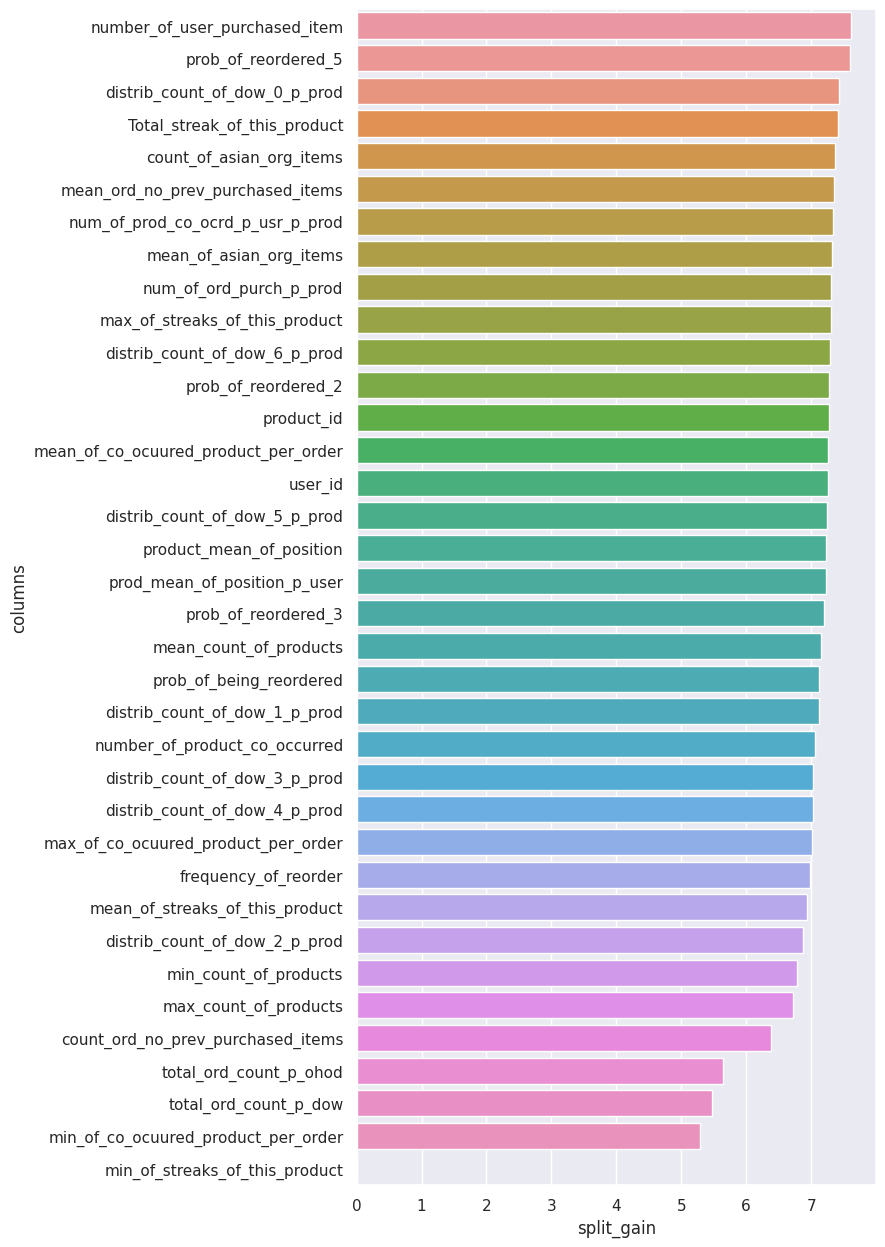

In [35]:
fig = sns.barplot(gain_df.sort_values('split_gain',ascending=False),y='columns',x='split_gain',orient='h')

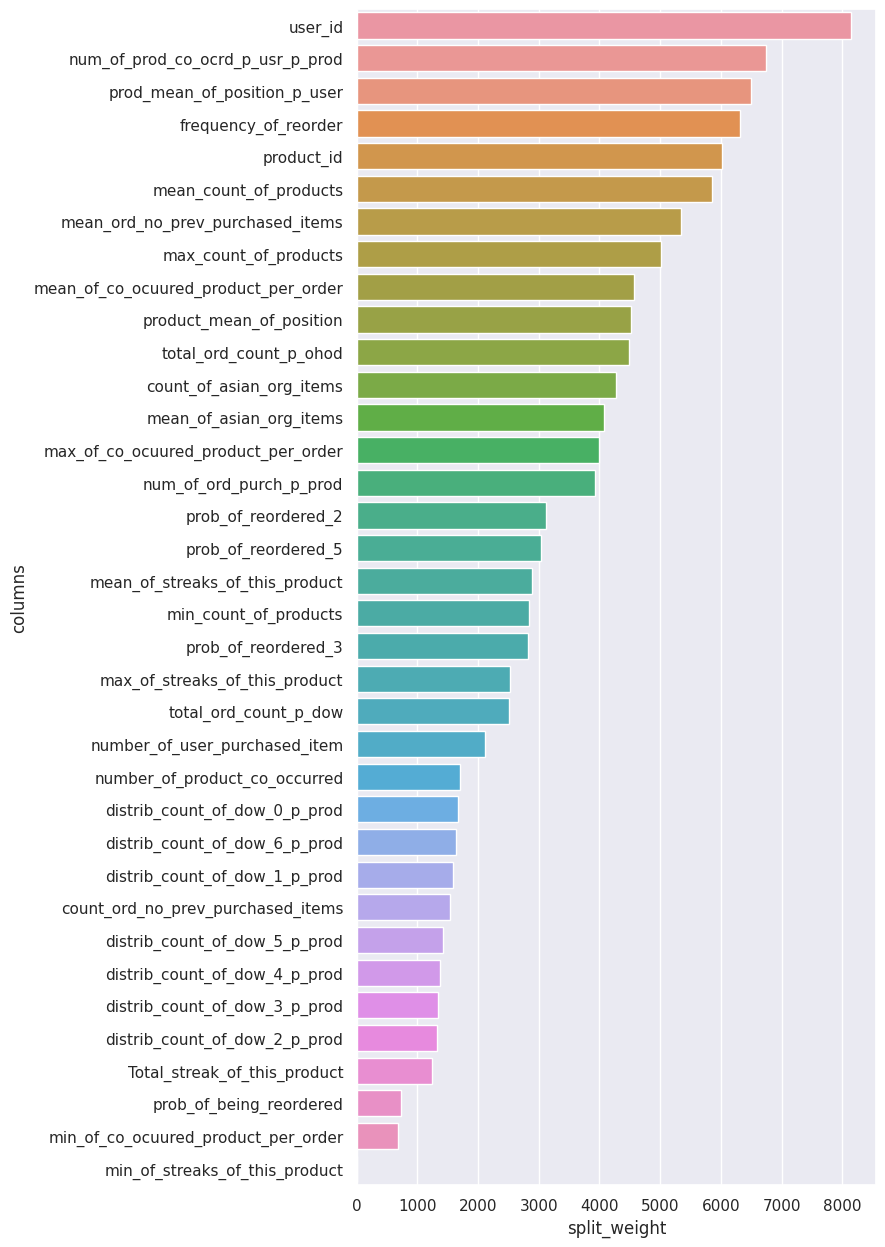

In [38]:
fig = sns.barplot(weight_df.sort_values('split_weight',ascending=False),y='columns',x='split_weight',orient='h')